### Geographic Data: Street Trees in Portland Neighborhoods
---
Research shows that different areas of the city hold heat more than others, creating geographic disparities in temperature. Hotter areas may have more concrete, less shade, or less tree cover. This has negative implications to people living in these areas and could create geographic health or wellness disparities, especially as the climate warms on the west coast.

I got the idea for this analysis from National Geographic's July 2021 issue about the tree cover in Los Angeles, finding that poorer communities of color had less access to shade. 
https://www.nationalgeographic.com/magazine/article/los-angeles-confronts-its-shady-divide-feature 

**So how does tree cover vary across my home of Portland, OR?**

Using geographic data from [Portland Maps](https://gis-pdx.opendata.arcgis.com/), I will present a dataframe of Portland census tracts that contains demographic information as well as the ratio of street trees or parks to overall area.

The goal is to practice geospatial analysis with geopandas.

In [2]:
import geopandas as gpd
import pandas as pd

**Data Resources:**
[Parks](https://gis-pdx.opendata.arcgis.com/datasets/PDX::parks/about): dataset containing parks boundaries in Portland.
[Street Trees](https://gis-pdx.opendata.arcgis.com/datasets/PDX::street-trees/about): a dataset from Portland Parks and Rec mapping all street trees. There are a lot of street trees in Portland!
[Vulnerability](https://gis-pdx.opendata.arcgis.com/datasets/PDX::vulnerability/about): a dataset of census tracts that contains measurements of vulnerability to gentrification as well as demographic details.

In [3]:
parks_link = "https://opendata.arcgis.com/datasets/9eef54196eaa4d12b54e9bc40e70ff09_35.geojson"
trees_link = "https://opendata.arcgis.com/datasets/eb67a0ad684d4bb6afda51dc065d1664_25.geojson"
census = "https://opendata.arcgis.com/datasets/2a41e30a633f440c8b8d5cd4e3ca112c_207.geojson"

PDX_parks = gpd.read_file(parks_link)
PDX_trees = gpd.read_file(trees_link)
PDX_tracts = gpd.read_file(census)

In [5]:
PDX_trees['tree_count'] = 1

<AxesSubplot:>

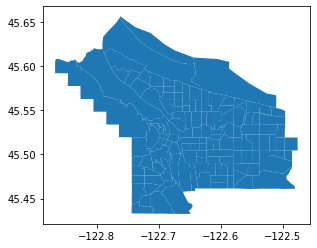

In [4]:
PDX_tracts.plot()

In [6]:
print(PDX_tracts.columns)
print(PDX_trees.columns)
print(PDX_parks.columns)

Index(['OBJECTID', 'STATE', 'COUNTY', 'TRACT', 'TRACT_NO', 'FIPS', 'Geography',
       'Perc_renters', 'Perc_com_color', 'Perc_WO_bachlrs_degree',
       'Perc_HHs_80_MFI', 'risk_renters', 'risk_com_color',
       'risk_25_WO_bachlrs_degree', 'risk_80_MFI', 'risk_total',
       'Shape_Length', 'Shape_Area', 'is_vulnerable', 'geometry'],
      dtype='object')
Index(['OBJECTID', 'Date_Inventoried', 'Species', 'DBH', 'Condition',
       'Site_Type', 'Site_Width', 'Wires', 'Site_development', 'Site_Size',
       'Notes', 'Address', 'Neighborhood', 'Collected_By', 'Planted_By',
       'Plant_Date', 'Scientific', 'Family', 'Genus', 'Common',
       'FunctionalType', 'Size', 'Edible', 'Species_Description', 'geometry',
       'tree_count'],
      dtype='object')
Index(['OBJECTID', 'PROPERTYID', 'NAME', 'ACRES', 'Shape_Length', 'Shape_Area',
       'geometry'],
      dtype='object')


First, join census tracts to trees to count the number of trees in each tract.

In [63]:
census_trees = gpd.sjoin(PDX_tracts, PDX_trees)

In [65]:
census_trees_summ = census_trees.groupby('OBJECTID_left', as_index=False)[['tree_count']].sum()
census_trees_summ.head()

,OBJECTID_left,tree_count
0,1,1057
1,2,2847
2,3,2229
3,4,1906
4,5,1412


In [78]:
census_joined = PDX_tracts.merge(census_trees_summ, how='left', left_on='OBJECTID', right_on='OBJECTID_left')

In [79]:
census_joined.head()

,OBJECTID,STATE,COUNTY,TRACT,TRACT_NO,FIPS,Geography,Perc_renters,Perc_com_color,Perc_WO_bachlrs_degree,...,risk_com_color,risk_25_WO_bachlrs_degree,risk_80_MFI,risk_total,Shape_Length,Shape_Area,is_vulnerable,geometry,OBJECTID_left,tree_count
0,1,41,051,005800,58.00,41051005800,"Census Tract 58, Multnomah County, Oregon",44.837758,19.266819,19.542110,...,1.0,0.0,1.0,4.0,19856.756077,7.735723e+06,N,"POLYGON ((-122.71067 45.50344, -122.71083 45.5...",1,1057
1,2,41,051,005900,59.00,41051005900,"Census Tract 59, Multnomah County, Oregon",63.059273,24.828362,23.924659,...,2.0,0.0,1.0,7.0,15884.999702,6.739968e+06,N,"POLYGON ((-122.67717 45.47443, -122.67696 45.4...",2,2847
2,3,41,051,007300,73.00,41051007300,"Census Tract 73, Multnomah County, Oregon",58.064516,32.425941,94.701987,...,3.0,4.0,4.0,14.0,42713.964714,6.373686e+07,Y,"POLYGON ((-122.61859 45.60862, -122.63498 45.6...",3,2229
3,4,41,051,003702,37.02,41051003702,"Census Tract 37.02, Multnomah County, Oregon",39.143135,28.263337,42.028986,...,2.0,2.0,1.0,7.0,5312.030843,1.732313e+06,N,"POLYGON ((-122.66145 45.56274, -122.66144 45.5...",4,1906
4,5,41,051,003801,38.01,41051003801,"Census Tract 38.01, Multnomah County, Oregon",40.756602,26.658244,47.797010,...,2.0,2.0,2.0,8.0,6747.965148,2.525771e+06,N,"POLYGON ((-122.67433 45.58229, -122.67433 45.5...",5,1412


Next, join parks to census_tract to measure the overlay.

In [70]:
merge_parks = gpd.overlay(PDX_tracts, PDX_parks, how='intersection')
merge_parks = merge_parks[['OBJECTID_1','OBJECTID_2','geometry']]
merge_parks = merge_parks.to_crs('epsg:3395')
merge_parks['area'] = merge_parks['geometry'].area

In [71]:
merge_parks.head()

,OBJECTID_1,OBJECTID_2,geometry,area
0,1,23,"MULTIPOLYGON (((-13659484.301 5669805.041, -13...",352644.006377
1,1,31,"MULTIPOLYGON (((-13657511.132 5670564.062, -13...",4065.569803
2,99,31,"POLYGON ((-13657409.421 5670581.753, -13657408...",111135.019075
3,1,55,"POLYGON ((-13658064.348 5671280.195, -13658064...",47129.545450
4,1,63,"POLYGON ((-13658720.787 5669025.420, -13658718...",9725.899062


In [72]:
census_parks_summ = merge_parks.groupby('OBJECTID_1', as_index=False)[['area']].sum()
census_parks_summ.rename(columns={"area":"parks_area"}, inplace=True)
census_parks_summ.head()

,OBJECTID_1,parks_area
0,1,1.499127e+06
1,2,4.280913e+05
2,3,1.655198e+06
3,4,1.344594e+05
4,5,1.021050e+05


Combine datasets and calculate areas and ratios.

In [80]:
census_joined = census_joined.merge(census_parks_summ, how='left', left_on='OBJECTID', right_on='OBJECTID_1')
census_joined.head()

,OBJECTID,STATE,COUNTY,TRACT,TRACT_NO,FIPS,Geography,Perc_renters,Perc_com_color,Perc_WO_bachlrs_degree,...,risk_80_MFI,risk_total,Shape_Length,Shape_Area,is_vulnerable,geometry,OBJECTID_left,tree_count,OBJECTID_1,parks_area
0,1,41,051,005800,58.00,41051005800,"Census Tract 58, Multnomah County, Oregon",44.837758,19.266819,19.542110,...,1.0,4.0,19856.756077,7.735723e+06,N,"POLYGON ((-122.71067 45.50344, -122.71083 45.5...",1,1057,1.0,1.499127e+06
1,2,41,051,005900,59.00,41051005900,"Census Tract 59, Multnomah County, Oregon",63.059273,24.828362,23.924659,...,1.0,7.0,15884.999702,6.739968e+06,N,"POLYGON ((-122.67717 45.47443, -122.67696 45.4...",2,2847,2.0,4.280913e+05
2,3,41,051,007300,73.00,41051007300,"Census Tract 73, Multnomah County, Oregon",58.064516,32.425941,94.701987,...,4.0,14.0,42713.964714,6.373686e+07,Y,"POLYGON ((-122.61859 45.60862, -122.63498 45.6...",3,2229,3.0,1.655198e+06
3,4,41,051,003702,37.02,41051003702,"Census Tract 37.02, Multnomah County, Oregon",39.143135,28.263337,42.028986,...,1.0,7.0,5312.030843,1.732313e+06,N,"POLYGON ((-122.66145 45.56274, -122.66144 45.5...",4,1906,4.0,1.344594e+05
4,5,41,051,003801,38.01,41051003801,"Census Tract 38.01, Multnomah County, Oregon",40.756602,26.658244,47.797010,...,2.0,8.0,6747.965148,2.525771e+06,N,"POLYGON ((-122.67433 45.58229, -122.67433 45.5...",5,1412,5.0,1.021050e+05


In [83]:
census_joined_new = census_joined.to_crs('epsg:3395')
census_joined_new['total_area'] = census_joined_new['geometry'].area
census_joined_new['park_area_ratio'] = census_joined_new['parks_area'] / census_joined_new['total_area']
census_joined_new['tree_area_ratio'] = census_joined_new['tree_count'] *1000 / census_joined_new['total_area']
census_joined_new.head()

,OBJECTID,STATE,COUNTY,TRACT,TRACT_NO,FIPS,Geography,Perc_renters,Perc_com_color,Perc_WO_bachlrs_degree,...,Shape_Area,is_vulnerable,geometry,OBJECTID_left,tree_count,OBJECTID_1,parks_area,total_area,park_area_ratio,tree_area_ratio
0,1,41,051,005800,58.00,41051005800,"Census Tract 58, Multnomah County, Oregon",44.837758,19.266819,19.542110,...,7.735723e+06,N,"POLYGON ((-13660088.860 5670639.028, -13660107...",1,1057,1.0,1.499127e+06,7.710195e+06,0.194434,0.137091
1,2,41,051,005900,59.00,41051005900,"Census Tract 59, Multnomah County, Oregon",63.059273,24.828362,23.924659,...,6.739968e+06,N,"POLYGON ((-13656359.854 5666047.422, -13656337...",2,2847,2.0,4.280913e+05,6.717714e+06,0.063726,0.423805
2,3,41,051,007300,73.00,41051007300,"Census Tract 73, Multnomah County, Oregon",58.064516,32.425941,94.701987,...,6.373686e+07,Y,"POLYGON ((-13649838.608 5687304.891, -13651663...",3,2229,3.0,1.655198e+06,6.352714e+07,0.026055,0.035087
3,4,41,051,003702,37.02,41051003702,"Census Tract 37.02, Multnomah County, Oregon",39.143135,28.263337,42.028986,...,1.732313e+06,N,"POLYGON ((-13654609.630 5680030.390, -13654608...",4,1906,4.0,1.344594e+05,1.726609e+06,0.077875,1.103898
4,5,41,051,003801,38.01,41051003801,"Census Tract 38.01, Multnomah County, Oregon",40.756602,26.658244,47.797010,...,2.525771e+06,N,"POLYGON ((-13656043.552 5683129.752, -13656044...",5,1412,5.0,1.021050e+05,2.517460e+06,0.040559,0.560883


In [90]:
census_joined_new.to_file("output.shp")

**To Do:**

- clean up and save output
- analyze for insights between dimensions
- visualization